In [1]:
import pandas as pd
import pylab as plt
%matplotlib inline
import numpy as np
import math

df=pd.read_csv('data/train.csv', sep=',')

features = ['Fare_s','Sex_', 'Title_s', 'Pclass_s', 'Age_s','HasAge','Parch_s', 'Cabin_s', 'Embarked_s']
#features = ['Sex_', 'Title_s', 'Pclass_s', 'Age_s']
#features = ['Sex_', 'Age_s_e']

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=0.1, random_state=0, n_jobs=-1, class_weight={0: 0.7, 1: 1-0.7})

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(5)

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


## Transform features

In [3]:
def feature_engineering(_df,title_mapping, cabin_mapping, embarked_mapping):
    _df['Sex_'] = _df['Sex'].apply(lambda x: 0 if x=='female' else 1)
    
    _df['Fare'] = _df['Fare'].fillna(10)
    _df['Fare'] = _df['Fare'].apply(lambda x: 40 if x > 40 else x)
    
    fareMax = _df['Fare'].max()
    fareMin = _df['Fare'].min()

    _df['Fare_s'] = (_df['Fare']-fareMin)/(fareMax-fareMin)
    
    _df['Pclass_s'] = _df['Pclass']/3
    
    _df['SibSp'] = _df['SibSp'].apply(lambda x: 3 if x > 3 else x)
    _df['SibSp_s'] = _df['SibSp']/_df['SibSp'].max()
    
    _df['Parch'] = _df['Parch'].apply(lambda x: 3 if x > 3 else x)
    _df['Parch_s'] = _df['Parch']/_df['Parch'].max()

    _df['HasAge'] = _df['Age'].apply(lambda x: 0 if np.isnan(x) else 1)

    _df['Age_'] = _df['Age'].fillna(24)
    _df['Age_'] = _df['Age_'].apply(lambda x: 1 if x <= 8 else x)
    _df['Age_'] = _df['Age_'].apply(lambda x: 10 if x >8 and x <= 15 else x)
    _df['Age_'] = _df['Age_'].apply(lambda x: 18 if x >15 and x <= 23 else x)
    _df['Age_'] = _df['Age_'].apply(lambda x: 24 if x >23 and x <= 24 else x)
    _df['Age_'] = _df['Age_'].apply(lambda x: 34 if x >24 and x <= 44 else x)
    _df['Age_'] = _df['Age_'].apply(lambda x: 50 if x >44 and x <= 54 else x)
    _df['Age_'] = _df['Age_'].apply(lambda x: 60 if x >54 else x)
    ageMax = _df['Age_'].max()
    ageMin = _df['Age_'].min()

    _df['Age_s'] = (_df['Age_']-ageMin)/(ageMax-ageMin)
    
    
    _df['Age_with_Sex'] = _df['Age_s'] + _df['Sex_']
    
    _df['Title'] = _df['Name'].apply(lambda x: x.replace('.',',').split(',')[1].strip())
    _df['Title_s'] = _df['Title'].map(title_mapping)
    _df['Title_s'] = _df['Title_s'].fillna(0);
    
    # Cabin:
    
    
    _df['Cabin_s'] = _df['Cabin_'].map(cabin_mapping)
    
    #
    _df['Embarked_'] = _df['Embarked'].apply(lambda x: 'S' if isinstance(x, float) else x)
    _df['Embarked_s'] = _df['Embarked_'].map(embarked_mapping)
    
########################



In [4]:
df['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

## Feature engineering

In [5]:
df['Title'] = df['Name'].apply(lambda x: x.replace('.',',').split(',')[1].strip())
df['Cabin_'] = df['Cabin'].apply(lambda x: 'X' if isinstance(x, float) else x[0])
df['Embarked_'] = df['Embarked'].apply(lambda x: 'S' if isinstance(x, float) else x)

title_mapping={}
for t in np.unique(df['Title']):
    x = df[df['Title'] == t]
    title_mapping[t] = 1 - x['Survived'].sum()/float(len(x['Survived']))

cabin_mapping={}
for t in np.unique(df['Cabin_']):
    x = df[df['Cabin_'] == t]
    cabin_mapping[t] = 1 - x['Survived'].sum()/float(len(x['Survived']))
    
embarked_mapping={}
for t in np.unique(df['Embarked_']):
    x = df[df['Embarked_'] == t]
    embarked_mapping[t] = 1 - x['Survived'].sum()/float(1+len(x['Survived']))

feature_engineering(df, title_mapping, cabin_mapping, embarked_mapping)



In [6]:
title_mapping

{'Capt': 1.0,
 'Col': 0.5,
 'Don': 1.0,
 'Dr': 0.5714285714285714,
 'Jonkheer': 1.0,
 'Lady': 0.0,
 'Major': 0.5,
 'Master': 0.42500000000000004,
 'Miss': 0.30219780219780223,
 'Mlle': 0.0,
 'Mme': 0.0,
 'Mr': 0.8433268858800773,
 'Mrs': 0.20799999999999996,
 'Ms': 0.0,
 'Rev': 1.0,
 'Sir': 0.0,
 'the Countess': 0.0}

In [7]:
cabin_mapping

{'A': 0.5333333333333333,
 'B': 0.25531914893617025,
 'C': 0.4067796610169492,
 'D': 0.24242424242424243,
 'E': 0.25,
 'F': 0.3846153846153846,
 'G': 0.5,
 'T': 1.0,
 'X': 0.7001455604075691}

In [8]:
embarked_mapping

{'C': 0.4497041420118343, 'Q': 0.6153846153846154, 'S': 0.6615146831530139}

In [9]:
df['Cabin_'].head()

0    X
1    C
2    X
3    C
4    X
Name: Cabin_, dtype: object

In [10]:
df['Cabin_s'].head()

0    0.700146
1    0.406780
2    0.700146
3    0.406780
4    0.700146
Name: Cabin_s, dtype: float64

(array([ 112.,   13.,   59.,   19.,    0.,    0.,  687.,    0.,    0.,    1.]),
 array([ 0.24242424,  0.31818182,  0.39393939,  0.46969697,  0.54545455,
         0.62121212,  0.6969697 ,  0.77272727,  0.84848485,  0.92424242,  1.        ]),
 <a list of 10 Patch objects>)

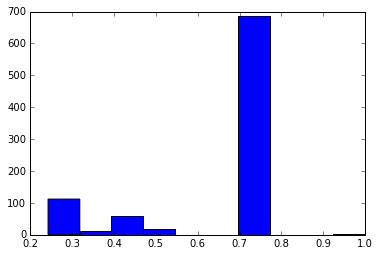

In [11]:
plt.hist(df['Cabin_s'])

(array([ 168.,    0.,    0.,  723.]),
 array([ 0.44970414,  0.50265678,  0.55560941,  0.60856205,  0.66151468]),
 <a list of 4 Patch objects>)

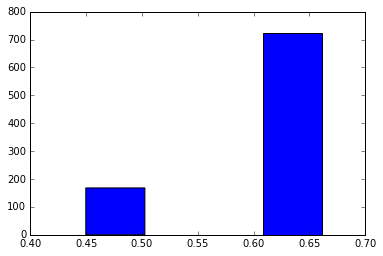

In [12]:
plt.hist(df['Embarked_s'], 4)

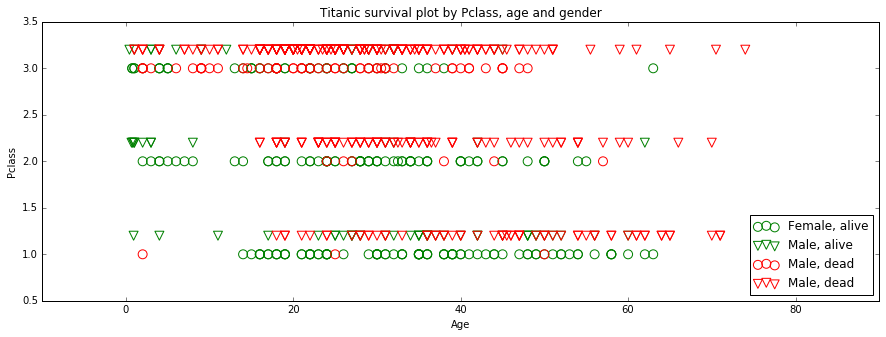

In [13]:
plt.figure(figsize=(15,5))

feature = 'Pclass'

df_1 = df[(df['Survived']==1) & (df['Sex_']==0)]
plt.scatter(df_1['Age'], df_1[feature], s=80,marker='o',facecolors='none', edgecolors='g', label='Female, alive')

df_1 = df[(df['Survived']==1) & (df['Sex_']==1)]
plt.scatter(df_1['Age'], df_1[feature]+0.2*df_1['Sex_'], s=80,marker='v',facecolors='none', edgecolors='g', label='Male, alive')

df_0 = df[(df['Survived']==0) & (df['Sex_']==0)]
plt.scatter(df_0['Age'], df_0[feature], s=80,marker='o',facecolors='none', edgecolors='r', label='Male, dead')

df_0 = df[(df['Survived']==0) & (df['Sex_']==1)]
plt.scatter(df_0['Age'], df_0[feature]+0.2*df_0['Sex_'], s=80,marker='v',facecolors='none', edgecolors='r', label='Male, dead')

plt.legend(loc='lower right')

plt.ylabel(feature)
plt.xlabel('Age')
plt.title('Titanic survival plot by Pclass, age and gender')

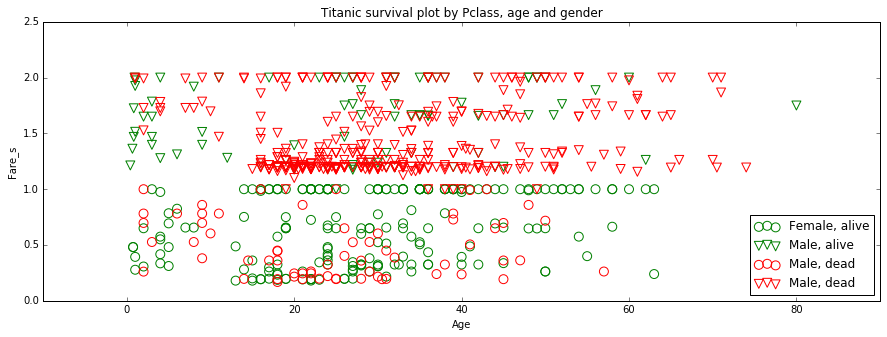

In [14]:
plt.figure(figsize=(15,5))

feature = 'Fare_s'

df_1 = df[(df['Survived']==1) & (df['Sex_']==0)]
plt.scatter(df_1['Age'], df_1[feature], s=80,marker='o',facecolors='none', edgecolors='g', label='Female, alive')

df_1 = df[(df['Survived']==1) & (df['Sex_']==1)]
plt.scatter(df_1['Age'], df_1[feature]+1*df_1['Sex_'], s=80,marker='v',facecolors='none', edgecolors='g', label='Male, alive')

df_0 = df[(df['Survived']==0) & (df['Sex_']==0)]
plt.scatter(df_0['Age'], df_0[feature], s=80,marker='o',facecolors='none', edgecolors='r', label='Male, dead')

df_0 = df[(df['Survived']==0) & (df['Sex_']==1)]
plt.scatter(df_0['Age'], df_0[feature]+1*df_0['Sex_'], s=80,marker='v',facecolors='none', edgecolors='r', label='Male, dead')

plt.legend(loc='lower right')

plt.ylabel(feature)
plt.xlabel('Age')
plt.title('Titanic survival plot by Pclass, age and gender')

## Simply remove some outlier

In [15]:
df[(df['Survived']==0) & (df['Sex_']==0) &(df['Pclass']==1) &(df['Age']<12)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_s,SibSp_s,Parch_s,HasAge,Age_,Age_s,Age_with_Sex,Title_s,Cabin_s,Embarked_s
297,298,0,1,"Allison, Miss. Helen Loraine",female,2,1,2,113781,40,...,0.333333,0.333333,0.666667,1,1,0,0,0.302198,0.40678,0.661515


In [16]:
df.loc[297, 'Survived'] = 1

In [17]:
df[(df['Survived']==0) & (df['Sex_']==0) &(df['Pclass']==1) &(df['Age']<12)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_s,SibSp_s,Parch_s,HasAge,Age_,Age_s,Age_with_Sex,Title_s,Cabin_s,Embarked_s


In [18]:
df[(df['Survived']==1) &(df['Pclass']>1) &(df['Age']>60)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_s,SibSp_s,Parch_s,HasAge,Age_,Age_s,Age_with_Sex,Title_s,Cabin_s,Embarked_s
483,484,1,3,"Turkula, Mrs. (Hedwig)",female,63,0,0,4134,9.5875,...,1.000000,0,0,1,60,1,1,0.208000,0.700146,0.661515
570,571,1,2,"Harris, Mr. George",male,62,0,0,S.W./PP 752,10.5000,...,0.666667,0,0,1,60,1,2,0.843327,0.700146,0.661515


In [19]:
df.loc[483,'Survived'] = 0
df.loc[570,'Survived'] = 0

## Study Model

### Random shaffle validation - (don't use this, use the KFold CV below instead)

In [20]:
def correct_rate(lr_model):
    correct_rate = 0.0
    correct_rate_train = 0.0

    number_run = 10
    for i in range(number_run):

        msk = np.random.rand(len(df)) < 0.8
        _train = df[msk]
        _validation = df[~msk]

        X_train = _train[features]
        X_train = poly.fit_transform(X_train)


        lr_model.fit(X_train ,_train['Survived'])

        X_validation = _validation[features]
        X_validation = poly.fit_transform(X_validation)

        #predict = lr_model.predict(X_validation)

        #correct_rate += accuracy_score(_validation['Survived'],predict)
        correct_rate += lr_model.score(X_validation, _validation['Survived'])
        correct_rate_train += lr_model.score(X_train, _train['Survived'])

    correct_rate = correct_rate/number_run
    correct_rate_train = correct_rate_train/number_run

    return (correct_rate, correct_rate_train)

In [21]:
# correct_rate(lr_model)

## K Fold cross validation

In [22]:
def correct_rate_KFold(_df, _lr_model,features, label, quiet=False):
    # call it as: correct_rate_KFold(df, lr_model, features, 'Survived')
    train_data =  poly.fit_transform(_df[features])
    kfold = StratifiedKFold(y=_df[label], n_folds=10, random_state=2)

    scores = []

    for k, (train, test) in enumerate(kfold):
        _lr_model.fit(train_data[train], _df[label][train])
        
        #score = _lr_model.score(train_data[test], _df[label][test])
        score_t = _lr_model.score(train_data[train], _df[label][train])
        
        prediction_test = _lr_model.predict(train_data[test])
        
        score = accuracy_score(y_true=_df[label][test], y_pred=prediction_test)
        p = precision_score(y_true=_df[label][test], y_pred=prediction_test)
        r = recall_score(y_true=_df[label][test], y_pred=prediction_test)
        f1 = f1_score(y_true=_df[label][test], y_pred=prediction_test)
        
        scores.append((score, score_t, p, r, f1))
        if not quiet:
            print('Fold: %s, Label dist.: %s, Acc: %.3f, Train_acc: %.3f, P: %.3f, R: %.3f, F1: %.3f' % (k+1,
                                                          np.bincount(df[label][train]),
                                                          score, score_t, p, r, f1
                                                         ))
    if not quiet:
        r = np.array(scores).mean(0)
        print('Total accuracy: %.3f Train_acc: %.3f, P: %.3f, R: %.3f, F1: %.3f' % tuple(r))
    return np.mean(np.array(scores),axis=0)

In [23]:
correct_rate_KFold(df, lr_model, features, 'Survived')

Fold: 1, Label dist.: [495 306], Acc: 0.756, Train_acc: 0.810, P: 0.933, R: 0.400, F1: 0.560
Fold: 2, Label dist.: [495 307], Acc: 0.775, Train_acc: 0.802, P: 1.000, R: 0.412, F1: 0.583
Fold: 3, Label dist.: [495 307], Acc: 0.742, Train_acc: 0.809, P: 0.824, R: 0.412, F1: 0.549
Fold: 4, Label dist.: [495 307], Acc: 0.876, Train_acc: 0.794, P: 0.926, R: 0.735, F1: 0.820
Fold: 5, Label dist.: [495 307], Acc: 0.820, Train_acc: 0.800, P: 1.000, R: 0.529, F1: 0.692
Fold: 6, Label dist.: [495 307], Acc: 0.820, Train_acc: 0.800, P: 0.950, R: 0.559, F1: 0.704
Fold: 7, Label dist.: [495 307], Acc: 0.831, Train_acc: 0.797, P: 1.000, R: 0.559, F1: 0.717
Fold: 8, Label dist.: [495 307], Acc: 0.764, Train_acc: 0.808, P: 1.000, R: 0.382, F1: 0.553
Fold: 9, Label dist.: [495 307], Acc: 0.831, Train_acc: 0.797, P: 0.952, R: 0.588, F1: 0.727
Fold: 10, Label dist.: [495 307], Acc: 0.820, Train_acc: 0.800, P: 0.950, R: 0.559, F1: 0.704
Total accuracy: 0.804 Train_acc: 0.802, P: 0.954, R: 0.514, F1: 0.661

array([ 0.80364544,  0.80184666,  0.95351696,  0.51352941,  0.66091855])

In [ ]:
plt.hist(df['Survived'], 3)

## Precision and Recall evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

msk = np.random.rand(len(df)) < 0.8
_train = df[msk]
_validation = df[~msk]

X_train = _train[features]
X_train = poly.fit_transform(X_train)


lr_model.fit(X_train ,_train['Survived'])

X_validation = _validation[features]
X_validation = poly.fit_transform(X_validation)
predict = lr_model.predict(X_validation)

confmat = confusion_matrix(y_true=_validation['Survived'], y_pred=predict)

print 'One test on a 8/2 split validation data:'
print ''
print(confmat)

print('Accuracy: %.3f' % accuracy_score(y_true=_validation['Survived'], y_pred=predict))
print('Precision: %.3f' % precision_score(y_true=_validation['Survived'], y_pred=predict))
print('Recall: %.3f' % recall_score(y_true=_validation['Survived'], y_pred=predict))
print('F1: %.3f' % f1_score(y_true=_validation['Survived'], y_pred=predict))

## Example - using cross_validation with f1 score

In [ ]:
from sklearn import cross_validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

threshold = []
scores = []
for t in np.linspace(0.3, 0.8, num=20):
    
    lr_model.class_weight = {0:t, 1:1-t}
    #f1_s = cross_validation.cross_val_score(lr_model,
    #                             poly.fit_transform(df[features]),
    #                             df['Survived'],
    #                             scoring='f1',
    #                             cv=8)
    
    predicted = cross_validation.cross_val_predict(lr_model, poly.fit_transform(df[features]),
                                                   df['Survived'], cv=8, n_jobs=-1)
    acc_s = accuracy_score(df['Survived'], predicted)
    p_s = precision_score(df['Survived'], predicted)
    r_s = recall_score(df['Survived'], predicted)
    f1_s = f1_score(df['Survived'], predicted)
    
    print('Threshold: %.3f, Acc: %.3f, P: %.3f, R: %.3f, F1: %.3f' % (t, acc_s, p_s, r_s, f1_s))
    threshold.append(t)
    scores.append(np.mean(f1_s))
    
    #http://stackoverflow.com/questions/19984957/scikit-predict-default-threshold

## Choose Threshold as 0.7

In [ ]:
class_weight={0: 0.7,
              1: 1-0.7}
lr_model.class_weight = class_weight
print lr_model

## Good results above

## Choosing C:

In [ ]:
C_para, score = [], []

for c in np.arange(-5, 8):
    lr = LogisticRegression(C=3**c, random_state=0, n_jobs=-1, class_weight=class_weight)
    rate = correct_rate_KFold(df, lr, features, 'Survived', quiet=True)
    C_para.append(3**c)
    score.append(rate)
    
    print('C: %f, acc: %.3f' % (3**c, rate[0]))

score = np.array(score)


In [ ]:
plt.plot(C_para, score[:,0], label='validation correct rate')
plt.plot(C_para, score[:,1], label='training correct rate')
plt.plot(C_para, score[:,2], label='validation precision')
plt.plot(C_para, score[:,3], label='validation recall')
plt.plot(C_para, score[:,4], label='validation F1')
plt.legend(loc='lower right')
plt.xscale('log')
print lr.class_weight

In [ ]:
n=3
print C_para[n]
print score[n]

## Choose C=0.1

## Train Model

In [ ]:
# Note, df has already been feature engineered above
X = df[features]
X = poly.fit_transform(X)

lr_model_pro = LogisticRegression(C=0.1, random_state=0, n_jobs=-1, class_weight=class_weight)

lr_model_pro.fit(X ,df['Survived'])

In [ ]:
pre = lr_model_pro.predict(X)
print 1 - (pre != df['Survived']).sum()/float(len(df))

#alternativly:

from sklearn import cross_validation
scores = cross_validation.cross_val_score(lr_model_pro,
                                 poly.fit_transform(df[features]),
                                 df['Survived'],
                                 scoring='accuracy',
                                 cv=8)
print scores.mean()
scores = cross_validation.cross_val_score(lr_model_pro,
                                 poly.fit_transform(df[features]),
                                 df['Survived'],
                                 scoring='precision',
                                 cv=8)
print scores.mean()

In [ ]:
print len(lr_model_pro.coef_[0])

In [ ]:
print X.shape

## Predict test

In [ ]:
test = pd.read_csv('data/test.csv', sep=',')

feature_engineering(test, title_mapping, cabin_mapping)

X_test = test[features]
X_test = poly.fit_transform(X_test)



test['Survived'] = lr_model.predict(X_test).astype(int)

In [ ]:
plt.hist(test['Survived'] )

In [ ]:
test

In [ ]:
np.unique(test['Title'])

In [ ]:
import csv as csv
predictions_file = open("LRmodel.rmOutlier.Od5.C0.1-thre0.721-acc0.79-p0.94.csv", "wb")
predictions_file_object = csv.writer(predictions_file)
predictions_file_object.writerow(["PassengerId", "Survived"])	# write the column headers
for index, row in test.iterrows():									# For each row in test file,
    predictions_file_object.writerow([row['PassengerId'], row['Survived']])			# write the PassengerId, and predict 1
predictions_file.close()